# 1. Import libraries

# References:
1. https://www.kaggle.com/xwxw2929/rossmann-sales-top1

In [61]:
import warnings
import pandas                  as pd
import seaborn                 as sns
import xgboost                 as xgb

from time                    import time
from matplotlib              import pyplot as plt
from IPython.core.display    import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn                 import linear_model
from sklearn                 import metrics

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
train = pd.read_csv( '../data/train.csv' )
test = pd.read_csv( '../data/test.csv' )
store = pd.read_csv( '../data/store.csv' )

# Merge dataset
#df_raw = pd.merge( df_sales_raw, df_stores_raw, on='Store', how='left' )

In [5]:
# fillna in store with 0 has better result than median()

#store['CompetitionDistance'].fillna( store['CompetitionDistance'].median(), inplace=True )
#store['CompetitionOpenSinceYear'].fillna( store['CompetitionDistance'].median(), inplace=True )
#store['CompetitionOpenSinceMonth'].fillna( store['CompetitionDistance'].median(), inplace=True )

# the store should be open in the test, so we fillna with 1
test.fillna( 1, inplace=True )

# fillna in store with 0 has better results than median()
store.fillna( 0, inplace=True )


In [6]:
# Merge dataset
train = pd.merge( train, store, on='Store' )
test = pd.merge( test, store, on='Store' )

# Change data columns types
train['Date'] = pd.to_datetime( train['Date'] )
test['Date'] = pd.to_datetime( test['Date'] )

In [7]:
train.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [8]:
# split the last 6 weeks data as hold-out set
train = train.sort_values( ['Date'], ascending=False )

ho_test = train[:6*7*1115]
ho_train = train[6*7*1115:]

In [9]:
# only use data of Sales > 0 and Open is 1
ho_test = ho_test[ ho_test['Open'] != 0 ]
ho_test = ho_test[ ho_test['Sales'] > 0 ]

ho_train = ho_train[ ho_train['Open'] != 0 ]
ho_train = ho_train[ ho_train['Sales'] > 0 ]

In [76]:
ho_train.sample( 2 )

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
825330,906,2,13422,1,0,0,1,1,90.0,7.0,2010.0,0,0.0,0.0,2013,12,4,49,41.0,24168.25,0
653064,718,2,6956,1,0,1,1,1,1100.0,6.0,2015.0,0,0.0,0.0,2014,10,22,43,0.0,24178.75,0


In [10]:
# feature creation
def features_create( data ):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace( mappings, inplace=True )
    data.Assortment.replace( mappings, inplace=True )
    data.StateHoliday.replace( mappings, inplace=True )
    
    data['StateHoliday'] = data['StateHoliday'].astype( int )
    data['Assortment'] = data['Assortment'].astype( int )
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    data['CompetitionOpen'] = 12 * ( data.Year - data.CompetitionOpenSinceYear ) + ( data.Month - data.CompetitionOpenSinceMonth )
    data['PromoOpen'] = 12 * ( data.Year - data.Promo2SinceYear ) + ( data.WeekOfYear - data.Promo2SinceWeek ) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply( lambda x: x if x > 0 else 0 )
    data['PromoOpen'] = data.PromoOpen.apply( lambda x: x if x > 0 else 0 )
    
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map( month2str )
    data.loc[ data.PromoInterval == 0, 'PromoInterval' ] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split( ',' ):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
                
    return data

In [12]:
features_create( ho_train )
features_create( ho_test )
features_create( test )
print( 'Features creation finished' )

Features creation finished


In [13]:
# drop the features of not help
ho_train.drop( ['Date', 'Customers', 'Open', 'PromoInterval', 'monthStr'], axis=1, inplace=True )
ho_test.drop( ['Date', 'Customers', 'Open', 'PromoInterval', 'monthStr'], axis=1, inplace=True )

In [79]:
ho_train.head( 3)

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
284584,314,4,5032,1,0,0,1,1,3560.0,10.0,2001.0,1,31.0,2013.0,2015,6,19,25,164.0,22.50,0
417104,458,4,7362,1,0,0,3,1,3390.0,0.0,0.0,0,0.0,0.0,2015,6,19,25,24186.0,24186.25,0
875290,961,4,7764,1,0,0,4,3,9430.0,0.0,0.0,0,0.0,0.0,2015,6,19,25,24186.0,24186.25,0


In [34]:
ho_xtrain = ho_train.drop( ['Sales'], axis=1 )
ho_ytrain = np.log1p( ho_train.Sales )

ho_xtest = ho_test.drop( ['Sales'], axis=1 )
ho_ytest = np.log1p( ho_test.Sales )

xtest = test.drop( ['Id', 'Date', 'Open', 'PromoInterval', 'monthStr'], axis=1 )

In [42]:
# define rmspe for xgb
def rmspe( y, yhat ):
    return np.sqrt( np.mean( ( yhat / y-1 )**2 ) )

def rmspe_xg( yhat,  y ):
    y = np.expm1( y.get_label() )
    yhat = np.expm1( yhat )
    return 'rmspe', rmspe( y, yhat )

In [43]:
params = {
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'silent': 1,
    'seed': 10 
}

num_boost_round = 6000

In [55]:
ho_xtrain.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
284584,314,4,1,0,0,1,1,3560.0,10.0,2001.0,1,31.0,2013.0,2015,6,19,25,164.0,22.50,0
417104,458,4,1,0,0,3,1,3390.0,0.0,0.0,0,0.0,0.0,2015,6,19,25,24186.0,24186.25,0
875290,961,4,1,0,0,4,3,9430.0,0.0,0.0,0,0.0,0.0,2015,6,19,25,24186.0,24186.25,0
119580,132,4,1,0,0,4,3,1040.0,0.0,0.0,1,27.0,2012.0,2015,6,19,25,24186.0,35.50,0
807974,887,4,1,0,0,4,1,19700.0,0.0,0.0,1,37.0,2009.0,2015,6,19,25,24186.0,69.00,0


In [59]:
ho_xtrain[ho_xtrain['Store'] == 314][['Store', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 
                                      'StateHoliday', 'SchoolHoliday', 
                                      'StoreType', 'Assortment',
                                      'Promo', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoOpen', 'IsPromoMonth',
                                      'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sort_values( ['Year', 'Month', 'Day'] ).head(3)


,Store,Year,Month,Day,DayOfWeek,WeekOfYear,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoOpen,IsPromoMonth,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
285482,314,2013,1,2,2,1,0,1,1,1,0,1,2013.0,31.0,0.0,0,3560.0,2001.0,10.0,135.0
285481,314,2013,1,3,3,1,0,1,1,1,0,1,2013.0,31.0,0.0,0,3560.0,2001.0,10.0,135.0
285480,314,2013,1,4,4,1,0,1,1,1,0,1,2013.0,31.0,0.0,0,3560.0,2001.0,10.0,135.0


In [62]:
dtrain = xgb.DMatrix( ho_xtrain, ho_ytrain )
dvalid = xgb.DMatrix( ho_xtest, ho_ytest )
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

print( 'Train a XGBoost model' )
start = time()
gbm = xgb.train( params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True )
end = time()

print( 'Training Time is: {:2f}'.format( end-start ) )

print( 'validating' )
ho_xtest.sort_index( inplace=True )
ho_ytest.sort_index( inplace=True )

yhat = gbm.predict( xgb.DMatrix( ho_xtest ) )
error = rmspe( np.expm1( ho_ytest ), np.expm1( yhat ) )

print( 'RMSPE: {:.6f}'.format( error ) )

Train a XGBoost model
[0]	train-rmse:8.02085	eval-rmse:8.02657	train-rmspe:0.999808	eval-rmspe:0.99981
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78077	eval-rmse:7.78599	train-rmspe:0.99971	eval-rmspe:0.999713
[2]	train-rmse:7.54779	eval-rmse:7.55333	train-rmspe:0.99959	eval-rmspe:0.999594
[3]	train-rmse:7.32185	eval-rmse:7.32777	train-rmspe:0.999444	eval-rmspe:0.99945
[4]	train-rmse:7.10269	eval-rmse:7.10895	train-rmspe:0.999267	eval-rmspe:0.999275
[5]	train-rmse:6.89007	eval-rmse:6.89644	train-rmspe:0.999055	eval-rmspe:0.999065
[6]	train-rmse:6.68387	eval-rmse:6.69022	train-rmspe:0.998801	eval-rmspe:0.998815
[7]	train-rmse:6.48386	eval-rmse:6.49076	train-rmspe:0.9985	eval-rmspe:0.998518
[8]	train-rmse:6.28991	eval-rmse:6.29693	train-rmspe:0.998144	eval-rmspe:0.998167
[9]	train-rmse:6.10175	eval-rmse:6.10921	train-rmspe:0.997728	eval-rmspe:0.997756
[10]	train-rmse:5.

[97]	train-rmse:0.488351	eval-rmse:0.481344	train-rmspe:0.378693	eval-rmspe:0.362076
[98]	train-rmse:0.477454	eval-rmse:0.470715	train-rmspe:0.372745	eval-rmspe:0.355796
[99]	train-rmse:0.466946	eval-rmse:0.460491	train-rmspe:0.36703	eval-rmspe:0.34972
[100]	train-rmse:0.456719	eval-rmse:0.450531	train-rmspe:0.361489	eval-rmspe:0.343805
[101]	train-rmse:0.446819	eval-rmse:0.440581	train-rmspe:0.356075	eval-rmspe:0.337896
[102]	train-rmse:0.437081	eval-rmse:0.43104	train-rmspe:0.350806	eval-rmspe:0.33222
[103]	train-rmse:0.428108	eval-rmse:0.422277	train-rmspe:0.345988	eval-rmspe:0.326979
[104]	train-rmse:0.419381	eval-rmse:0.413731	train-rmspe:0.341251	eval-rmspe:0.321877
[105]	train-rmse:0.411057	eval-rmse:0.405505	train-rmspe:0.336636	eval-rmspe:0.316949
[106]	train-rmse:0.40275	eval-rmse:0.397274	train-rmspe:0.332208	eval-rmspe:0.312047
[107]	train-rmse:0.395067	eval-rmse:0.389916	train-rmspe:0.328136	eval-rmspe:0.307704
[108]	train-rmse:0.387227	eval-rmse:0.382505	train-rmspe:0.323

[193]	train-rmse:0.198647	eval-rmse:0.207037	train-rmspe:0.244124	eval-rmspe:0.219056
[194]	train-rmse:0.197685	eval-rmse:0.206267	train-rmspe:0.243442	eval-rmspe:0.218464
[195]	train-rmse:0.197301	eval-rmse:0.205954	train-rmspe:0.243235	eval-rmspe:0.218328
[196]	train-rmse:0.196273	eval-rmse:0.205017	train-rmspe:0.242528	eval-rmspe:0.217449
[197]	train-rmse:0.195276	eval-rmse:0.204068	train-rmspe:0.24181	eval-rmspe:0.216587
[198]	train-rmse:0.194301	eval-rmse:0.203093	train-rmspe:0.241138	eval-rmspe:0.215745
[199]	train-rmse:0.193488	eval-rmse:0.202369	train-rmspe:0.240657	eval-rmspe:0.215179
[200]	train-rmse:0.192569	eval-rmse:0.201579	train-rmspe:0.239997	eval-rmspe:0.214576
[201]	train-rmse:0.191666	eval-rmse:0.200792	train-rmspe:0.239234	eval-rmspe:0.213878
[202]	train-rmse:0.19108	eval-rmse:0.200364	train-rmspe:0.237548	eval-rmspe:0.213482
[203]	train-rmse:0.190839	eval-rmse:0.200249	train-rmspe:0.237506	eval-rmspe:0.213552
[204]	train-rmse:0.189633	eval-rmse:0.199173	train-rmspe

[289]	train-rmse:0.157403	eval-rmse:0.172343	train-rmspe:0.202164	eval-rmspe:0.187358
[290]	train-rmse:0.157174	eval-rmse:0.172149	train-rmspe:0.201819	eval-rmspe:0.187168
[291]	train-rmse:0.156978	eval-rmse:0.172022	train-rmspe:0.201643	eval-rmspe:0.187043
[292]	train-rmse:0.156868	eval-rmse:0.172085	train-rmspe:0.201522	eval-rmspe:0.187144
[293]	train-rmse:0.156096	eval-rmse:0.171398	train-rmspe:0.200844	eval-rmspe:0.18642
[294]	train-rmse:0.155849	eval-rmse:0.17118	train-rmspe:0.200625	eval-rmspe:0.18619
[295]	train-rmse:0.155312	eval-rmse:0.170763	train-rmspe:0.200147	eval-rmspe:0.185758
[296]	train-rmse:0.155154	eval-rmse:0.170671	train-rmspe:0.199571	eval-rmspe:0.185651
[297]	train-rmse:0.154783	eval-rmse:0.170422	train-rmspe:0.199265	eval-rmspe:0.185418
[298]	train-rmse:0.15416	eval-rmse:0.169844	train-rmspe:0.198686	eval-rmspe:0.184758
[299]	train-rmse:0.15368	eval-rmse:0.169382	train-rmspe:0.198303	eval-rmspe:0.184248
[300]	train-rmse:0.153116	eval-rmse:0.16886	train-rmspe:0.1

[385]	train-rmse:0.132941	eval-rmse:0.152148	train-rmspe:0.172131	eval-rmspe:0.165422
[386]	train-rmse:0.13268	eval-rmse:0.151952	train-rmspe:0.171907	eval-rmspe:0.165224
[387]	train-rmse:0.132592	eval-rmse:0.151927	train-rmspe:0.171776	eval-rmspe:0.165209
[388]	train-rmse:0.132384	eval-rmse:0.151696	train-rmspe:0.171582	eval-rmspe:0.16495
[389]	train-rmse:0.132173	eval-rmse:0.151505	train-rmspe:0.171398	eval-rmspe:0.164724
[390]	train-rmse:0.132012	eval-rmse:0.151376	train-rmspe:0.171295	eval-rmspe:0.164585
[391]	train-rmse:0.131819	eval-rmse:0.151223	train-rmspe:0.171125	eval-rmspe:0.164424
[392]	train-rmse:0.131395	eval-rmse:0.150904	train-rmspe:0.170696	eval-rmspe:0.164038
[393]	train-rmse:0.131266	eval-rmse:0.150794	train-rmspe:0.170581	eval-rmspe:0.163917
[394]	train-rmse:0.130998	eval-rmse:0.150562	train-rmspe:0.170336	eval-rmspe:0.16365
[395]	train-rmse:0.130777	eval-rmse:0.150393	train-rmspe:0.170137	eval-rmspe:0.163463
[396]	train-rmse:0.130695	eval-rmse:0.150429	train-rmspe:

[481]	train-rmse:0.119172	eval-rmse:0.141953	train-rmspe:0.151715	eval-rmspe:0.154234
[482]	train-rmse:0.119093	eval-rmse:0.141902	train-rmspe:0.151647	eval-rmspe:0.154179
[483]	train-rmse:0.119035	eval-rmse:0.141873	train-rmspe:0.151596	eval-rmspe:0.154149
[484]	train-rmse:0.118921	eval-rmse:0.14178	train-rmspe:0.151495	eval-rmspe:0.154041
[485]	train-rmse:0.118719	eval-rmse:0.14162	train-rmspe:0.151317	eval-rmspe:0.153871
[486]	train-rmse:0.118624	eval-rmse:0.141532	train-rmspe:0.151196	eval-rmspe:0.15376
[487]	train-rmse:0.118572	eval-rmse:0.141488	train-rmspe:0.151153	eval-rmspe:0.153726
[488]	train-rmse:0.118433	eval-rmse:0.141398	train-rmspe:0.151019	eval-rmspe:0.153628
[489]	train-rmse:0.118321	eval-rmse:0.141389	train-rmspe:0.150887	eval-rmspe:0.153649
[490]	train-rmse:0.118249	eval-rmse:0.141329	train-rmspe:0.150861	eval-rmspe:0.153579
[491]	train-rmse:0.118215	eval-rmse:0.141305	train-rmspe:0.150803	eval-rmspe:0.153552
[492]	train-rmse:0.118024	eval-rmse:0.141145	train-rmspe:

[577]	train-rmse:0.110312	eval-rmse:0.135139	train-rmspe:0.13978	eval-rmspe:0.146733
[578]	train-rmse:0.110222	eval-rmse:0.135072	train-rmspe:0.139695	eval-rmspe:0.146655
[579]	train-rmse:0.110088	eval-rmse:0.134989	train-rmspe:0.139571	eval-rmspe:0.146567
[580]	train-rmse:0.11002	eval-rmse:0.134936	train-rmspe:0.139503	eval-rmspe:0.146518
[581]	train-rmse:0.10993	eval-rmse:0.134884	train-rmspe:0.13938	eval-rmspe:0.146465
[582]	train-rmse:0.109775	eval-rmse:0.13477	train-rmspe:0.139271	eval-rmspe:0.146344
[583]	train-rmse:0.109696	eval-rmse:0.134715	train-rmspe:0.1392	eval-rmspe:0.146283
[584]	train-rmse:0.109669	eval-rmse:0.134624	train-rmspe:0.13918	eval-rmspe:0.146166
[585]	train-rmse:0.109567	eval-rmse:0.134544	train-rmspe:0.139082	eval-rmspe:0.146055
[586]	train-rmse:0.109537	eval-rmse:0.134525	train-rmspe:0.139028	eval-rmspe:0.146038
[587]	train-rmse:0.109411	eval-rmse:0.134422	train-rmspe:0.138748	eval-rmspe:0.145916
[588]	train-rmse:0.109394	eval-rmse:0.134406	train-rmspe:0.138

[673]	train-rmse:0.103378	eval-rmse:0.130064	train-rmspe:0.131359	eval-rmspe:0.140848
[674]	train-rmse:0.103268	eval-rmse:0.130022	train-rmspe:0.131226	eval-rmspe:0.140808
[675]	train-rmse:0.10325	eval-rmse:0.130008	train-rmspe:0.13121	eval-rmspe:0.140794
[676]	train-rmse:0.103162	eval-rmse:0.129956	train-rmspe:0.131112	eval-rmspe:0.14074
[677]	train-rmse:0.103123	eval-rmse:0.129958	train-rmspe:0.131051	eval-rmspe:0.140747
[678]	train-rmse:0.103032	eval-rmse:0.129922	train-rmspe:0.130955	eval-rmspe:0.140711
[679]	train-rmse:0.102947	eval-rmse:0.129869	train-rmspe:0.13088	eval-rmspe:0.14065
[680]	train-rmse:0.102922	eval-rmse:0.12984	train-rmspe:0.130853	eval-rmspe:0.14062
[681]	train-rmse:0.102885	eval-rmse:0.12984	train-rmspe:0.130819	eval-rmspe:0.140627
[682]	train-rmse:0.102817	eval-rmse:0.129794	train-rmspe:0.130763	eval-rmspe:0.140577
[683]	train-rmse:0.102776	eval-rmse:0.129775	train-rmspe:0.130725	eval-rmspe:0.140553
[684]	train-rmse:0.102697	eval-rmse:0.129726	train-rmspe:0.130

[769]	train-rmse:0.098579	eval-rmse:0.126997	train-rmspe:0.125824	eval-rmspe:0.137425
[770]	train-rmse:0.098525	eval-rmse:0.126967	train-rmspe:0.125774	eval-rmspe:0.137389
[771]	train-rmse:0.098511	eval-rmse:0.126961	train-rmspe:0.12422	eval-rmspe:0.137384
[772]	train-rmse:0.098466	eval-rmse:0.12693	train-rmspe:0.124183	eval-rmspe:0.137349
[773]	train-rmse:0.098436	eval-rmse:0.126918	train-rmspe:0.124138	eval-rmspe:0.137337
[774]	train-rmse:0.098399	eval-rmse:0.126891	train-rmspe:0.124088	eval-rmspe:0.137309
[775]	train-rmse:0.098386	eval-rmse:0.126881	train-rmspe:0.124018	eval-rmspe:0.137299
[776]	train-rmse:0.098364	eval-rmse:0.126865	train-rmspe:0.123997	eval-rmspe:0.137286
[777]	train-rmse:0.098293	eval-rmse:0.126821	train-rmspe:0.123935	eval-rmspe:0.13724
[778]	train-rmse:0.098268	eval-rmse:0.126811	train-rmspe:0.12387	eval-rmspe:0.137232
[779]	train-rmse:0.098233	eval-rmse:0.126813	train-rmspe:0.123834	eval-rmspe:0.13725
[780]	train-rmse:0.098205	eval-rmse:0.1268	train-rmspe:0.12

[865]	train-rmse:0.094942	eval-rmse:0.125031	train-rmspe:0.120221	eval-rmspe:0.135412
[866]	train-rmse:0.094905	eval-rmse:0.125028	train-rmspe:0.120178	eval-rmspe:0.135411
[867]	train-rmse:0.094871	eval-rmse:0.125013	train-rmspe:0.120147	eval-rmspe:0.1354
[868]	train-rmse:0.094856	eval-rmse:0.125025	train-rmspe:0.119989	eval-rmspe:0.135417
[869]	train-rmse:0.094836	eval-rmse:0.125021	train-rmspe:0.11997	eval-rmspe:0.135415
[870]	train-rmse:0.094813	eval-rmse:0.125014	train-rmspe:0.119944	eval-rmspe:0.135407
[871]	train-rmse:0.094777	eval-rmse:0.125001	train-rmspe:0.119911	eval-rmspe:0.135394
[872]	train-rmse:0.094737	eval-rmse:0.124978	train-rmspe:0.119871	eval-rmspe:0.135374
[873]	train-rmse:0.094693	eval-rmse:0.124955	train-rmspe:0.119821	eval-rmspe:0.135351
[874]	train-rmse:0.094688	eval-rmse:0.124953	train-rmspe:0.119817	eval-rmspe:0.135349
[875]	train-rmse:0.094671	eval-rmse:0.124944	train-rmspe:0.119798	eval-rmspe:0.13534
[876]	train-rmse:0.094652	eval-rmse:0.124948	train-rmspe:0

[961]	train-rmse:0.091907	eval-rmse:0.123572	train-rmspe:0.114189	eval-rmspe:0.133877
[962]	train-rmse:0.091877	eval-rmse:0.12356	train-rmspe:0.114151	eval-rmspe:0.133864
[963]	train-rmse:0.091859	eval-rmse:0.12352	train-rmspe:0.114135	eval-rmspe:0.133816
[964]	train-rmse:0.091842	eval-rmse:0.12351	train-rmspe:0.11412	eval-rmspe:0.133805
[965]	train-rmse:0.091808	eval-rmse:0.12349	train-rmspe:0.11409	eval-rmspe:0.133782
[966]	train-rmse:0.091786	eval-rmse:0.123464	train-rmspe:0.114056	eval-rmspe:0.13376
[967]	train-rmse:0.091748	eval-rmse:0.123445	train-rmspe:0.11397	eval-rmspe:0.133744
[968]	train-rmse:0.091721	eval-rmse:0.123429	train-rmspe:0.113946	eval-rmspe:0.133724
[969]	train-rmse:0.091702	eval-rmse:0.123429	train-rmspe:0.11393	eval-rmspe:0.133722
[970]	train-rmse:0.091667	eval-rmse:0.123406	train-rmspe:0.113898	eval-rmspe:0.133694
[971]	train-rmse:0.091647	eval-rmse:0.12339	train-rmspe:0.113881	eval-rmspe:0.133673
[972]	train-rmse:0.091624	eval-rmse:0.123381	train-rmspe:0.11386

[1057]	train-rmse:0.089375	eval-rmse:0.122815	train-rmspe:0.108407	eval-rmspe:0.133137
[1058]	train-rmse:0.089335	eval-rmse:0.122796	train-rmspe:0.108153	eval-rmspe:0.133117
[1059]	train-rmse:0.089316	eval-rmse:0.122804	train-rmspe:0.108133	eval-rmspe:0.133131
[1060]	train-rmse:0.089283	eval-rmse:0.122836	train-rmspe:0.10809	eval-rmspe:0.133184
[1061]	train-rmse:0.089258	eval-rmse:0.122827	train-rmspe:0.108065	eval-rmspe:0.133175
[1062]	train-rmse:0.089222	eval-rmse:0.122809	train-rmspe:0.108021	eval-rmspe:0.133159
[1063]	train-rmse:0.089185	eval-rmse:0.122788	train-rmspe:0.107979	eval-rmspe:0.133131
[1064]	train-rmse:0.089173	eval-rmse:0.122778	train-rmspe:0.107958	eval-rmspe:0.133118
[1065]	train-rmse:0.089151	eval-rmse:0.122775	train-rmspe:0.107843	eval-rmspe:0.133118
[1066]	train-rmse:0.089129	eval-rmse:0.122766	train-rmspe:0.107826	eval-rmspe:0.133109
[1067]	train-rmse:0.089102	eval-rmse:0.12274	train-rmspe:0.107796	eval-rmspe:0.133067
[1068]	train-rmse:0.089088	eval-rmse:0.122733

[1152]	train-rmse:0.087192	eval-rmse:0.122087	train-rmspe:0.105532	eval-rmspe:0.132382
[1153]	train-rmse:0.087169	eval-rmse:0.122075	train-rmspe:0.105512	eval-rmspe:0.132368
[1154]	train-rmse:0.087163	eval-rmse:0.122068	train-rmspe:0.105497	eval-rmspe:0.132358
[1155]	train-rmse:0.087141	eval-rmse:0.122057	train-rmspe:0.105475	eval-rmspe:0.132341
[1156]	train-rmse:0.087119	eval-rmse:0.122059	train-rmspe:0.105424	eval-rmspe:0.132342
[1157]	train-rmse:0.08708	eval-rmse:0.122049	train-rmspe:0.105275	eval-rmspe:0.132333
[1158]	train-rmse:0.087051	eval-rmse:0.121988	train-rmspe:0.10524	eval-rmspe:0.132253
[1159]	train-rmse:0.087029	eval-rmse:0.121983	train-rmspe:0.105157	eval-rmspe:0.13225
[1160]	train-rmse:0.086995	eval-rmse:0.121966	train-rmspe:0.10511	eval-rmspe:0.132235
[1161]	train-rmse:0.086966	eval-rmse:0.121948	train-rmspe:0.105083	eval-rmspe:0.132215
[1162]	train-rmse:0.086942	eval-rmse:0.121938	train-rmspe:0.105057	eval-rmspe:0.132204
[1163]	train-rmse:0.086924	eval-rmse:0.121933	t

[1247]	train-rmse:0.085194	eval-rmse:0.121432	train-rmspe:0.102485	eval-rmspe:0.131664
[1248]	train-rmse:0.085157	eval-rmse:0.121431	train-rmspe:0.102416	eval-rmspe:0.131655
[1249]	train-rmse:0.085142	eval-rmse:0.121429	train-rmspe:0.1024	eval-rmspe:0.131656
[1250]	train-rmse:0.085127	eval-rmse:0.121411	train-rmspe:0.102385	eval-rmspe:0.131635
[1251]	train-rmse:0.085109	eval-rmse:0.121415	train-rmspe:0.102368	eval-rmspe:0.131643
[1252]	train-rmse:0.085095	eval-rmse:0.121415	train-rmspe:0.102348	eval-rmspe:0.131639
[1253]	train-rmse:0.085073	eval-rmse:0.121407	train-rmspe:0.102294	eval-rmspe:0.131632
[1254]	train-rmse:0.085061	eval-rmse:0.121409	train-rmspe:0.102281	eval-rmspe:0.13163
[1255]	train-rmse:0.085044	eval-rmse:0.121403	train-rmspe:0.102267	eval-rmspe:0.13162
[1256]	train-rmse:0.085029	eval-rmse:0.121381	train-rmspe:0.102253	eval-rmspe:0.131601
[1257]	train-rmse:0.085004	eval-rmse:0.121374	train-rmspe:0.102231	eval-rmspe:0.131596
[1258]	train-rmse:0.084971	eval-rmse:0.121381	t

[1342]	train-rmse:0.083503	eval-rmse:0.120808	train-rmspe:0.10048	eval-rmspe:0.13094
[1343]	train-rmse:0.083482	eval-rmse:0.120798	train-rmspe:0.100462	eval-rmspe:0.130925
[1344]	train-rmse:0.083472	eval-rmse:0.120788	train-rmspe:0.100449	eval-rmspe:0.130914
[1345]	train-rmse:0.08346	eval-rmse:0.12079	train-rmspe:0.100435	eval-rmspe:0.130918
[1346]	train-rmse:0.083447	eval-rmse:0.120786	train-rmspe:0.100422	eval-rmspe:0.130915
[1347]	train-rmse:0.083429	eval-rmse:0.120773	train-rmspe:0.099829	eval-rmspe:0.130902
[1348]	train-rmse:0.083419	eval-rmse:0.120772	train-rmspe:0.099819	eval-rmspe:0.1309
[1349]	train-rmse:0.083393	eval-rmse:0.120759	train-rmspe:0.099793	eval-rmspe:0.130885
[1350]	train-rmse:0.083371	eval-rmse:0.120752	train-rmspe:0.099851	eval-rmspe:0.130878
[1351]	train-rmse:0.083356	eval-rmse:0.120746	train-rmspe:0.099828	eval-rmspe:0.130872
[1352]	train-rmse:0.083344	eval-rmse:0.120744	train-rmspe:0.099815	eval-rmspe:0.13087
[1353]	train-rmse:0.083332	eval-rmse:0.12074	train

[1437]	train-rmse:0.081953	eval-rmse:0.120384	train-rmspe:0.097387	eval-rmspe:0.13047
[1438]	train-rmse:0.08194	eval-rmse:0.12038	train-rmspe:0.097365	eval-rmspe:0.130467
[1439]	train-rmse:0.081922	eval-rmse:0.120372	train-rmspe:0.096616	eval-rmspe:0.130458
[1440]	train-rmse:0.08189	eval-rmse:0.120354	train-rmspe:0.096584	eval-rmspe:0.130439
[1441]	train-rmse:0.081874	eval-rmse:0.120351	train-rmspe:0.096567	eval-rmspe:0.130433
[1442]	train-rmse:0.081861	eval-rmse:0.120345	train-rmspe:0.096526	eval-rmspe:0.130428
[1443]	train-rmse:0.081843	eval-rmse:0.120342	train-rmspe:0.096499	eval-rmspe:0.130424
[1444]	train-rmse:0.081832	eval-rmse:0.120346	train-rmspe:0.096487	eval-rmspe:0.130429
[1445]	train-rmse:0.081823	eval-rmse:0.120346	train-rmspe:0.096474	eval-rmspe:0.13043
[1446]	train-rmse:0.081805	eval-rmse:0.120344	train-rmspe:0.09645	eval-rmspe:0.130432
[1447]	train-rmse:0.081801	eval-rmse:0.120342	train-rmspe:0.096446	eval-rmspe:0.130428
[1448]	train-rmse:0.08179	eval-rmse:0.120337	trai

[1532]	train-rmse:0.080495	eval-rmse:0.119945	train-rmspe:0.092719	eval-rmspe:0.130019
[1533]	train-rmse:0.080477	eval-rmse:0.119938	train-rmspe:0.0927	eval-rmspe:0.130007
[1534]	train-rmse:0.080467	eval-rmse:0.119931	train-rmspe:0.092688	eval-rmspe:0.13
[1535]	train-rmse:0.080457	eval-rmse:0.119935	train-rmspe:0.092676	eval-rmspe:0.130005
[1536]	train-rmse:0.080439	eval-rmse:0.119931	train-rmspe:0.092655	eval-rmspe:0.130001
[1537]	train-rmse:0.080427	eval-rmse:0.11994	train-rmspe:0.092642	eval-rmspe:0.130011
[1538]	train-rmse:0.080416	eval-rmse:0.119937	train-rmspe:0.092632	eval-rmspe:0.130006
[1539]	train-rmse:0.080396	eval-rmse:0.119925	train-rmspe:0.092606	eval-rmspe:0.12999
[1540]	train-rmse:0.080383	eval-rmse:0.119922	train-rmspe:0.092586	eval-rmspe:0.129986
[1541]	train-rmse:0.080367	eval-rmse:0.119914	train-rmspe:0.09257	eval-rmspe:0.129978
[1542]	train-rmse:0.080351	eval-rmse:0.11991	train-rmspe:0.092553	eval-rmspe:0.129973
[1543]	train-rmse:0.080333	eval-rmse:0.119902	train-r

[1627]	train-rmse:0.079193	eval-rmse:0.119553	train-rmspe:0.090079	eval-rmspe:0.129568
[1628]	train-rmse:0.079179	eval-rmse:0.119548	train-rmspe:0.09006	eval-rmspe:0.129564
[1629]	train-rmse:0.079171	eval-rmse:0.119549	train-rmspe:0.09005	eval-rmspe:0.129566
[1630]	train-rmse:0.07916	eval-rmse:0.119549	train-rmspe:0.09004	eval-rmspe:0.129566
[1631]	train-rmse:0.079147	eval-rmse:0.119541	train-rmspe:0.090026	eval-rmspe:0.129557
[1632]	train-rmse:0.07913	eval-rmse:0.119536	train-rmspe:0.090004	eval-rmspe:0.129552
[1633]	train-rmse:0.079116	eval-rmse:0.119532	train-rmspe:0.08999	eval-rmspe:0.129548
[1634]	train-rmse:0.079105	eval-rmse:0.11953	train-rmspe:0.08965	eval-rmspe:0.129545
[1635]	train-rmse:0.079091	eval-rmse:0.119526	train-rmspe:0.08963	eval-rmspe:0.129542
[1636]	train-rmse:0.079077	eval-rmse:0.119522	train-rmspe:0.089607	eval-rmspe:0.129538
[1637]	train-rmse:0.079062	eval-rmse:0.119513	train-rmspe:0.089587	eval-rmspe:0.12953
[1638]	train-rmse:0.079048	eval-rmse:0.119509	train-r

[1722]	train-rmse:0.078037	eval-rmse:0.119305	train-rmspe:0.08827	eval-rmspe:0.129285
[1723]	train-rmse:0.078024	eval-rmse:0.119304	train-rmspe:0.088245	eval-rmspe:0.129284
[1724]	train-rmse:0.078011	eval-rmse:0.119301	train-rmspe:0.088232	eval-rmspe:0.129284
[1725]	train-rmse:0.077998	eval-rmse:0.119291	train-rmspe:0.08822	eval-rmspe:0.129272
[1726]	train-rmse:0.077985	eval-rmse:0.119289	train-rmspe:0.088207	eval-rmspe:0.129271
[1727]	train-rmse:0.077972	eval-rmse:0.119289	train-rmspe:0.088193	eval-rmspe:0.129274
[1728]	train-rmse:0.077958	eval-rmse:0.119284	train-rmspe:0.088178	eval-rmspe:0.129268
[1729]	train-rmse:0.077948	eval-rmse:0.119283	train-rmspe:0.088168	eval-rmspe:0.129268
[1730]	train-rmse:0.077934	eval-rmse:0.119281	train-rmspe:0.088155	eval-rmspe:0.129268
[1731]	train-rmse:0.077919	eval-rmse:0.119276	train-rmspe:0.088138	eval-rmspe:0.129264
[1732]	train-rmse:0.07791	eval-rmse:0.119276	train-rmspe:0.088129	eval-rmspe:0.129264
[1733]	train-rmse:0.077898	eval-rmse:0.119276	

[1817]	train-rmse:0.076923	eval-rmse:0.119059	train-rmspe:0.08697	eval-rmspe:0.129054
[1818]	train-rmse:0.076904	eval-rmse:0.119051	train-rmspe:0.086944	eval-rmspe:0.129047
[1819]	train-rmse:0.076898	eval-rmse:0.119051	train-rmspe:0.086935	eval-rmspe:0.129048
[1820]	train-rmse:0.076881	eval-rmse:0.119068	train-rmspe:0.086912	eval-rmspe:0.129068
[1821]	train-rmse:0.076874	eval-rmse:0.11907	train-rmspe:0.086902	eval-rmspe:0.129072
[1822]	train-rmse:0.076856	eval-rmse:0.119063	train-rmspe:0.08688	eval-rmspe:0.129064
[1823]	train-rmse:0.076844	eval-rmse:0.119062	train-rmspe:0.086867	eval-rmspe:0.129063
[1824]	train-rmse:0.076838	eval-rmse:0.119057	train-rmspe:0.086861	eval-rmspe:0.129058
[1825]	train-rmse:0.07683	eval-rmse:0.119057	train-rmspe:0.086853	eval-rmspe:0.129057
[1826]	train-rmse:0.076822	eval-rmse:0.119062	train-rmspe:0.086842	eval-rmspe:0.129065
[1827]	train-rmse:0.076807	eval-rmse:0.119057	train-rmspe:0.086826	eval-rmspe:0.129058
[1828]	train-rmse:0.076793	eval-rmse:0.11906	tr

[1912]	train-rmse:0.075905	eval-rmse:0.118912	train-rmspe:0.084799	eval-rmspe:0.128919
[1913]	train-rmse:0.075893	eval-rmse:0.118905	train-rmspe:0.084786	eval-rmspe:0.12891
[1914]	train-rmse:0.075876	eval-rmse:0.1189	train-rmspe:0.084768	eval-rmspe:0.128902
[1915]	train-rmse:0.075859	eval-rmse:0.118898	train-rmspe:0.084745	eval-rmspe:0.1289
[1916]	train-rmse:0.075848	eval-rmse:0.118897	train-rmspe:0.084733	eval-rmspe:0.128898
[1917]	train-rmse:0.075829	eval-rmse:0.118886	train-rmspe:0.084714	eval-rmspe:0.128889
[1918]	train-rmse:0.075818	eval-rmse:0.118885	train-rmspe:0.084698	eval-rmspe:0.128887
[1919]	train-rmse:0.075805	eval-rmse:0.118886	train-rmspe:0.084684	eval-rmspe:0.128889
[1920]	train-rmse:0.075793	eval-rmse:0.118887	train-rmspe:0.084664	eval-rmspe:0.128888
[1921]	train-rmse:0.075785	eval-rmse:0.118887	train-rmspe:0.084656	eval-rmspe:0.12889
[1922]	train-rmse:0.075762	eval-rmse:0.118878	train-rmspe:0.084646	eval-rmspe:0.128878
[1923]	train-rmse:0.075748	eval-rmse:0.118874	tra

[2007]	train-rmse:0.07486	eval-rmse:0.118669	train-rmspe:0.083011	eval-rmspe:0.128654
[2008]	train-rmse:0.074851	eval-rmse:0.118675	train-rmspe:0.083002	eval-rmspe:0.128661
[2009]	train-rmse:0.07484	eval-rmse:0.118671	train-rmspe:0.08299	eval-rmspe:0.128656
[2010]	train-rmse:0.074831	eval-rmse:0.11867	train-rmspe:0.08298	eval-rmspe:0.128652
[2011]	train-rmse:0.074823	eval-rmse:0.118668	train-rmspe:0.082964	eval-rmspe:0.12865
[2012]	train-rmse:0.074811	eval-rmse:0.118667	train-rmspe:0.082947	eval-rmspe:0.128647
[2013]	train-rmse:0.074799	eval-rmse:0.118664	train-rmspe:0.082932	eval-rmspe:0.128642
[2014]	train-rmse:0.074782	eval-rmse:0.118667	train-rmspe:0.082844	eval-rmspe:0.128644
[2015]	train-rmse:0.074775	eval-rmse:0.118665	train-rmspe:0.082836	eval-rmspe:0.12864
[2016]	train-rmse:0.074761	eval-rmse:0.118663	train-rmspe:0.082708	eval-rmspe:0.128639
[2017]	train-rmse:0.074756	eval-rmse:0.118663	train-rmspe:0.082703	eval-rmspe:0.128638
[2018]	train-rmse:0.074745	eval-rmse:0.118663	trai

[2102]	train-rmse:0.073962	eval-rmse:0.118528	train-rmspe:0.081692	eval-rmspe:0.128494
[2103]	train-rmse:0.073954	eval-rmse:0.118526	train-rmspe:0.081683	eval-rmspe:0.128495
[2104]	train-rmse:0.073946	eval-rmse:0.118525	train-rmspe:0.081676	eval-rmspe:0.128494
[2105]	train-rmse:0.073932	eval-rmse:0.118525	train-rmspe:0.081655	eval-rmspe:0.128494
[2106]	train-rmse:0.073925	eval-rmse:0.118526	train-rmspe:0.081647	eval-rmspe:0.128495
[2107]	train-rmse:0.073917	eval-rmse:0.118522	train-rmspe:0.081638	eval-rmspe:0.12849
[2108]	train-rmse:0.073906	eval-rmse:0.118524	train-rmspe:0.081622	eval-rmspe:0.128493
[2109]	train-rmse:0.073896	eval-rmse:0.118521	train-rmspe:0.081611	eval-rmspe:0.128491
[2110]	train-rmse:0.073885	eval-rmse:0.118521	train-rmspe:0.081591	eval-rmspe:0.12849
[2111]	train-rmse:0.073879	eval-rmse:0.11852	train-rmspe:0.081583	eval-rmspe:0.128489
[2112]	train-rmse:0.073868	eval-rmse:0.118519	train-rmspe:0.081572	eval-rmspe:0.128488
[2113]	train-rmse:0.073861	eval-rmse:0.118519	

[2197]	train-rmse:0.073078	eval-rmse:0.118416	train-rmspe:0.080102	eval-rmspe:0.128403
[2198]	train-rmse:0.07307	eval-rmse:0.118415	train-rmspe:0.080103	eval-rmspe:0.128403
[2199]	train-rmse:0.073057	eval-rmse:0.118426	train-rmspe:0.080084	eval-rmspe:0.128419
[2200]	train-rmse:0.073038	eval-rmse:0.118423	train-rmspe:0.080052	eval-rmspe:0.128419
[2201]	train-rmse:0.07303	eval-rmse:0.118422	train-rmspe:0.080042	eval-rmspe:0.128418
[2202]	train-rmse:0.073022	eval-rmse:0.118423	train-rmspe:0.080033	eval-rmspe:0.128419
[2203]	train-rmse:0.073011	eval-rmse:0.118423	train-rmspe:0.080017	eval-rmspe:0.128421
[2204]	train-rmse:0.073003	eval-rmse:0.118422	train-rmspe:0.080009	eval-rmspe:0.128419
[2205]	train-rmse:0.072994	eval-rmse:0.118422	train-rmspe:0.079999	eval-rmspe:0.128419
[2206]	train-rmse:0.072989	eval-rmse:0.118421	train-rmspe:0.079994	eval-rmspe:0.128418
[2207]	train-rmse:0.072982	eval-rmse:0.118422	train-rmspe:0.079987	eval-rmspe:0.12842
[2208]	train-rmse:0.072971	eval-rmse:0.118423	

[2292]	train-rmse:0.072227	eval-rmse:0.118279	train-rmspe:0.078872	eval-rmspe:0.128255
[2293]	train-rmse:0.072215	eval-rmse:0.118276	train-rmspe:0.078762	eval-rmspe:0.128251
[2294]	train-rmse:0.072207	eval-rmse:0.118276	train-rmspe:0.078752	eval-rmspe:0.128251
[2295]	train-rmse:0.072196	eval-rmse:0.118287	train-rmspe:0.07874	eval-rmspe:0.128267
[2296]	train-rmse:0.072181	eval-rmse:0.118281	train-rmspe:0.078718	eval-rmspe:0.12826
[2297]	train-rmse:0.072172	eval-rmse:0.118269	train-rmspe:0.078673	eval-rmspe:0.128244
[2298]	train-rmse:0.072165	eval-rmse:0.118268	train-rmspe:0.078665	eval-rmspe:0.128242
[2299]	train-rmse:0.072156	eval-rmse:0.118266	train-rmspe:0.078654	eval-rmspe:0.128234
[2300]	train-rmse:0.072143	eval-rmse:0.118263	train-rmspe:0.07864	eval-rmspe:0.128231
[2301]	train-rmse:0.072134	eval-rmse:0.118263	train-rmspe:0.078628	eval-rmspe:0.128231
[2302]	train-rmse:0.072126	eval-rmse:0.118263	train-rmspe:0.07862	eval-rmspe:0.128234
[2303]	train-rmse:0.072115	eval-rmse:0.118261	t

[2387]	train-rmse:0.071411	eval-rmse:0.118156	train-rmspe:0.077692	eval-rmspe:0.128109
[2388]	train-rmse:0.071401	eval-rmse:0.118156	train-rmspe:0.077679	eval-rmspe:0.128108
[2389]	train-rmse:0.071392	eval-rmse:0.118157	train-rmspe:0.077668	eval-rmspe:0.128109
[2390]	train-rmse:0.071385	eval-rmse:0.118149	train-rmspe:0.07766	eval-rmspe:0.1281
[2391]	train-rmse:0.071375	eval-rmse:0.11815	train-rmspe:0.077648	eval-rmspe:0.128101
[2392]	train-rmse:0.071367	eval-rmse:0.118149	train-rmspe:0.07764	eval-rmspe:0.128101
[2393]	train-rmse:0.071359	eval-rmse:0.11815	train-rmspe:0.077621	eval-rmspe:0.128103
[2394]	train-rmse:0.07135	eval-rmse:0.118149	train-rmspe:0.077611	eval-rmspe:0.128102
[2395]	train-rmse:0.071344	eval-rmse:0.118158	train-rmspe:0.077604	eval-rmspe:0.128118
[2396]	train-rmse:0.071337	eval-rmse:0.11816	train-rmspe:0.077597	eval-rmspe:0.128119
[2397]	train-rmse:0.071328	eval-rmse:0.118164	train-rmspe:0.077584	eval-rmspe:0.128126
[2398]	train-rmse:0.07132	eval-rmse:0.118163	train-

[2482]	train-rmse:0.070645	eval-rmse:0.118052	train-rmspe:0.076556	eval-rmspe:0.12799
[2483]	train-rmse:0.070634	eval-rmse:0.118046	train-rmspe:0.07654	eval-rmspe:0.127981
[2484]	train-rmse:0.070623	eval-rmse:0.118043	train-rmspe:0.076525	eval-rmspe:0.127977
[2485]	train-rmse:0.070613	eval-rmse:0.118041	train-rmspe:0.076512	eval-rmspe:0.127974
[2486]	train-rmse:0.070604	eval-rmse:0.118043	train-rmspe:0.076501	eval-rmspe:0.127978
[2487]	train-rmse:0.070594	eval-rmse:0.118041	train-rmspe:0.076488	eval-rmspe:0.127974
[2488]	train-rmse:0.070587	eval-rmse:0.11804	train-rmspe:0.076477	eval-rmspe:0.127975
[2489]	train-rmse:0.07058	eval-rmse:0.118042	train-rmspe:0.076468	eval-rmspe:0.127977
[2490]	train-rmse:0.070572	eval-rmse:0.118044	train-rmspe:0.07646	eval-rmspe:0.12798
[2491]	train-rmse:0.070563	eval-rmse:0.118041	train-rmspe:0.07645	eval-rmspe:0.127978
[2492]	train-rmse:0.070555	eval-rmse:0.118039	train-rmspe:0.076441	eval-rmspe:0.127975
[2493]	train-rmse:0.070548	eval-rmse:0.118037	trai

[2577]	train-rmse:0.069877	eval-rmse:0.117933	train-rmspe:0.075425	eval-rmspe:0.127882
[2578]	train-rmse:0.069868	eval-rmse:0.117929	train-rmspe:0.075407	eval-rmspe:0.127877
[2579]	train-rmse:0.069861	eval-rmse:0.117933	train-rmspe:0.075397	eval-rmspe:0.127883
[2580]	train-rmse:0.069852	eval-rmse:0.117925	train-rmspe:0.075385	eval-rmspe:0.127873
[2581]	train-rmse:0.069844	eval-rmse:0.117923	train-rmspe:0.075376	eval-rmspe:0.127871
[2582]	train-rmse:0.069836	eval-rmse:0.117922	train-rmspe:0.075365	eval-rmspe:0.12787
[2583]	train-rmse:0.069829	eval-rmse:0.117923	train-rmspe:0.075357	eval-rmspe:0.127872
[2584]	train-rmse:0.069818	eval-rmse:0.117919	train-rmspe:0.075343	eval-rmspe:0.127868
[2585]	train-rmse:0.069812	eval-rmse:0.117917	train-rmspe:0.075334	eval-rmspe:0.127866
[2586]	train-rmse:0.069806	eval-rmse:0.117915	train-rmspe:0.075328	eval-rmspe:0.127864
[2587]	train-rmse:0.0698	eval-rmse:0.117915	train-rmspe:0.075321	eval-rmspe:0.127862
[2588]	train-rmse:0.069794	eval-rmse:0.117916	

[2672]	train-rmse:0.069157	eval-rmse:0.117894	train-rmspe:0.074459	eval-rmspe:0.127871
[2673]	train-rmse:0.069149	eval-rmse:0.117892	train-rmspe:0.07445	eval-rmspe:0.127868
[2674]	train-rmse:0.069143	eval-rmse:0.117895	train-rmspe:0.074444	eval-rmspe:0.12787
[2675]	train-rmse:0.069135	eval-rmse:0.117892	train-rmspe:0.074434	eval-rmspe:0.127866
[2676]	train-rmse:0.069128	eval-rmse:0.117891	train-rmspe:0.074425	eval-rmspe:0.127864
[2677]	train-rmse:0.069116	eval-rmse:0.117887	train-rmspe:0.074401	eval-rmspe:0.127861
[2678]	train-rmse:0.069107	eval-rmse:0.117885	train-rmspe:0.074386	eval-rmspe:0.127859
[2679]	train-rmse:0.069098	eval-rmse:0.117882	train-rmspe:0.074373	eval-rmspe:0.127857
[2680]	train-rmse:0.069091	eval-rmse:0.11788	train-rmspe:0.074363	eval-rmspe:0.127853
[2681]	train-rmse:0.069085	eval-rmse:0.117881	train-rmspe:0.074353	eval-rmspe:0.127855
[2682]	train-rmse:0.069076	eval-rmse:0.117881	train-rmspe:0.074343	eval-rmspe:0.127854
[2683]	train-rmse:0.069066	eval-rmse:0.11788	t

[2767]	train-rmse:0.068479	eval-rmse:0.117858	train-rmspe:0.073477	eval-rmspe:0.127832
[2768]	train-rmse:0.068471	eval-rmse:0.117856	train-rmspe:0.073467	eval-rmspe:0.127828
[2769]	train-rmse:0.068463	eval-rmse:0.117855	train-rmspe:0.073458	eval-rmspe:0.127827
[2770]	train-rmse:0.068457	eval-rmse:0.117859	train-rmspe:0.073449	eval-rmspe:0.127833
[2771]	train-rmse:0.068452	eval-rmse:0.117859	train-rmspe:0.073444	eval-rmspe:0.127834
[2772]	train-rmse:0.068447	eval-rmse:0.117858	train-rmspe:0.073436	eval-rmspe:0.127833
[2773]	train-rmse:0.068442	eval-rmse:0.117856	train-rmspe:0.073431	eval-rmspe:0.127831
[2774]	train-rmse:0.068437	eval-rmse:0.117856	train-rmspe:0.073426	eval-rmspe:0.127831
[2775]	train-rmse:0.06843	eval-rmse:0.117856	train-rmspe:0.07342	eval-rmspe:0.12783
[2776]	train-rmse:0.068423	eval-rmse:0.117854	train-rmspe:0.073412	eval-rmspe:0.127826
[2777]	train-rmse:0.068418	eval-rmse:0.117851	train-rmspe:0.073407	eval-rmspe:0.127821
[2778]	train-rmse:0.068409	eval-rmse:0.117851	

[2862]	train-rmse:0.067799	eval-rmse:0.117807	train-rmspe:0.072414	eval-rmspe:0.127759
[2863]	train-rmse:0.067793	eval-rmse:0.117807	train-rmspe:0.072408	eval-rmspe:0.12776
[2864]	train-rmse:0.067788	eval-rmse:0.117804	train-rmspe:0.072401	eval-rmspe:0.127758
[2865]	train-rmse:0.067784	eval-rmse:0.117802	train-rmspe:0.072398	eval-rmspe:0.127757
[2866]	train-rmse:0.067781	eval-rmse:0.117801	train-rmspe:0.072394	eval-rmspe:0.127755
[2867]	train-rmse:0.067772	eval-rmse:0.117798	train-rmspe:0.072383	eval-rmspe:0.127754
[2868]	train-rmse:0.067764	eval-rmse:0.117796	train-rmspe:0.072374	eval-rmspe:0.127751
[2869]	train-rmse:0.067753	eval-rmse:0.117797	train-rmspe:0.072354	eval-rmspe:0.127752
[2870]	train-rmse:0.067748	eval-rmse:0.117796	train-rmspe:0.072348	eval-rmspe:0.127751
[2871]	train-rmse:0.067742	eval-rmse:0.117793	train-rmspe:0.072343	eval-rmspe:0.127745
[2872]	train-rmse:0.067733	eval-rmse:0.117789	train-rmspe:0.072333	eval-rmspe:0.127742
[2873]	train-rmse:0.067728	eval-rmse:0.11779

[2957]	train-rmse:0.067157	eval-rmse:0.117755	train-rmspe:0.071509	eval-rmspe:0.127706
[2958]	train-rmse:0.067148	eval-rmse:0.117753	train-rmspe:0.071496	eval-rmspe:0.127703
[2959]	train-rmse:0.06714	eval-rmse:0.11775	train-rmspe:0.071488	eval-rmspe:0.1277
[2960]	train-rmse:0.067132	eval-rmse:0.117748	train-rmspe:0.071475	eval-rmspe:0.127699
[2961]	train-rmse:0.067122	eval-rmse:0.117754	train-rmspe:0.071458	eval-rmspe:0.127706
[2962]	train-rmse:0.067117	eval-rmse:0.117753	train-rmspe:0.071453	eval-rmspe:0.127706
[2963]	train-rmse:0.067109	eval-rmse:0.11775	train-rmspe:0.071442	eval-rmspe:0.127702
[2964]	train-rmse:0.067102	eval-rmse:0.117744	train-rmspe:0.071435	eval-rmspe:0.127691
[2965]	train-rmse:0.067093	eval-rmse:0.117743	train-rmspe:0.071424	eval-rmspe:0.12769
[2966]	train-rmse:0.067083	eval-rmse:0.117741	train-rmspe:0.071412	eval-rmspe:0.127686
[2967]	train-rmse:0.067078	eval-rmse:0.117741	train-rmspe:0.071407	eval-rmspe:0.127685
[2968]	train-rmse:0.067074	eval-rmse:0.11774	trai

[3052]	train-rmse:0.06652	eval-rmse:0.117723	train-rmspe:0.070634	eval-rmspe:0.127683
[3053]	train-rmse:0.066512	eval-rmse:0.11772	train-rmspe:0.070625	eval-rmspe:0.127678
[3054]	train-rmse:0.066504	eval-rmse:0.117716	train-rmspe:0.070617	eval-rmspe:0.127675
[3055]	train-rmse:0.066498	eval-rmse:0.117714	train-rmspe:0.070611	eval-rmspe:0.127676
[3056]	train-rmse:0.066494	eval-rmse:0.117714	train-rmspe:0.070606	eval-rmspe:0.127677
[3057]	train-rmse:0.066483	eval-rmse:0.117711	train-rmspe:0.070594	eval-rmspe:0.127673
[3058]	train-rmse:0.066474	eval-rmse:0.11771	train-rmspe:0.070585	eval-rmspe:0.12767
[3059]	train-rmse:0.066467	eval-rmse:0.117705	train-rmspe:0.070574	eval-rmspe:0.127662
[3060]	train-rmse:0.06646	eval-rmse:0.117702	train-rmspe:0.070565	eval-rmspe:0.127659
[3061]	train-rmse:0.066454	eval-rmse:0.117704	train-rmspe:0.070559	eval-rmspe:0.127661
[3062]	train-rmse:0.066446	eval-rmse:0.1177	train-rmspe:0.070548	eval-rmspe:0.127658
[3063]	train-rmse:0.066441	eval-rmse:0.117699	trai

[3147]	train-rmse:0.065906	eval-rmse:0.11759	train-rmspe:0.069852	eval-rmspe:0.127515
[3148]	train-rmse:0.065902	eval-rmse:0.11759	train-rmspe:0.069848	eval-rmspe:0.127515
[3149]	train-rmse:0.065898	eval-rmse:0.117589	train-rmspe:0.069841	eval-rmspe:0.127513
[3150]	train-rmse:0.06589	eval-rmse:0.117588	train-rmspe:0.069832	eval-rmspe:0.127511
[3151]	train-rmse:0.065884	eval-rmse:0.11759	train-rmspe:0.069824	eval-rmspe:0.12751
[3152]	train-rmse:0.065876	eval-rmse:0.117589	train-rmspe:0.069812	eval-rmspe:0.127508
[3153]	train-rmse:0.06587	eval-rmse:0.11759	train-rmspe:0.069799	eval-rmspe:0.12751
[3154]	train-rmse:0.065866	eval-rmse:0.117589	train-rmspe:0.069794	eval-rmspe:0.127509
[3155]	train-rmse:0.06586	eval-rmse:0.11759	train-rmspe:0.069788	eval-rmspe:0.12751
[3156]	train-rmse:0.065854	eval-rmse:0.117588	train-rmspe:0.06978	eval-rmspe:0.127508
[3157]	train-rmse:0.065848	eval-rmse:0.117588	train-rmspe:0.069773	eval-rmspe:0.127509
[3158]	train-rmse:0.065842	eval-rmse:0.117588	train-rms

[3242]	train-rmse:0.065334	eval-rmse:0.117567	train-rmspe:0.069121	eval-rmspe:0.127486
[3243]	train-rmse:0.065327	eval-rmse:0.117565	train-rmspe:0.069112	eval-rmspe:0.127484
[3244]	train-rmse:0.06532	eval-rmse:0.117566	train-rmspe:0.069104	eval-rmspe:0.127485
[3245]	train-rmse:0.065314	eval-rmse:0.117564	train-rmspe:0.069098	eval-rmspe:0.127482
[3246]	train-rmse:0.065307	eval-rmse:0.117563	train-rmspe:0.06909	eval-rmspe:0.127479
[3247]	train-rmse:0.065301	eval-rmse:0.117564	train-rmspe:0.069081	eval-rmspe:0.127482
[3248]	train-rmse:0.065296	eval-rmse:0.117565	train-rmspe:0.069076	eval-rmspe:0.127484
[3249]	train-rmse:0.06529	eval-rmse:0.117565	train-rmspe:0.069068	eval-rmspe:0.127485
[3250]	train-rmse:0.065284	eval-rmse:0.117564	train-rmspe:0.069062	eval-rmspe:0.127484
[3251]	train-rmse:0.065278	eval-rmse:0.117565	train-rmspe:0.069054	eval-rmspe:0.127485
[3252]	train-rmse:0.065275	eval-rmse:0.117564	train-rmspe:0.069051	eval-rmspe:0.127484
[3253]	train-rmse:0.065271	eval-rmse:0.117563	

In [94]:
# analysis by hold-out set
res = pd.DataFrame( data = np.expm1( ho_ytest ) )
res['Prediction'] = np.expm1( yhat )

res = pd.merge( ho_xtest, res, left_index=True, right_index=True )
res['Ratio'] = res.Prediction/res.Sales
res['Error'] = abs( res.Ratio-1 )
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
0,1,4,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,31,31,82.0,24187.75,0,5263.0,5370.755859,1.020474,0.020474,0.979937
1,1,3,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,30,31,82.0,24187.75,0,5020.0,5181.497559,1.032171,0.032171,0.968832
2,1,2,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,29,31,82.0,24187.75,0,4782.0,4646.847656,0.971737,0.028263,1.029085
3,1,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,28,31,82.0,24187.75,0,5011.0,4799.076172,0.957708,0.042292,1.044159
4,1,0,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,27,31,82.0,24187.75,0,6102.0,5141.177246,0.842540,0.157460,1.186888


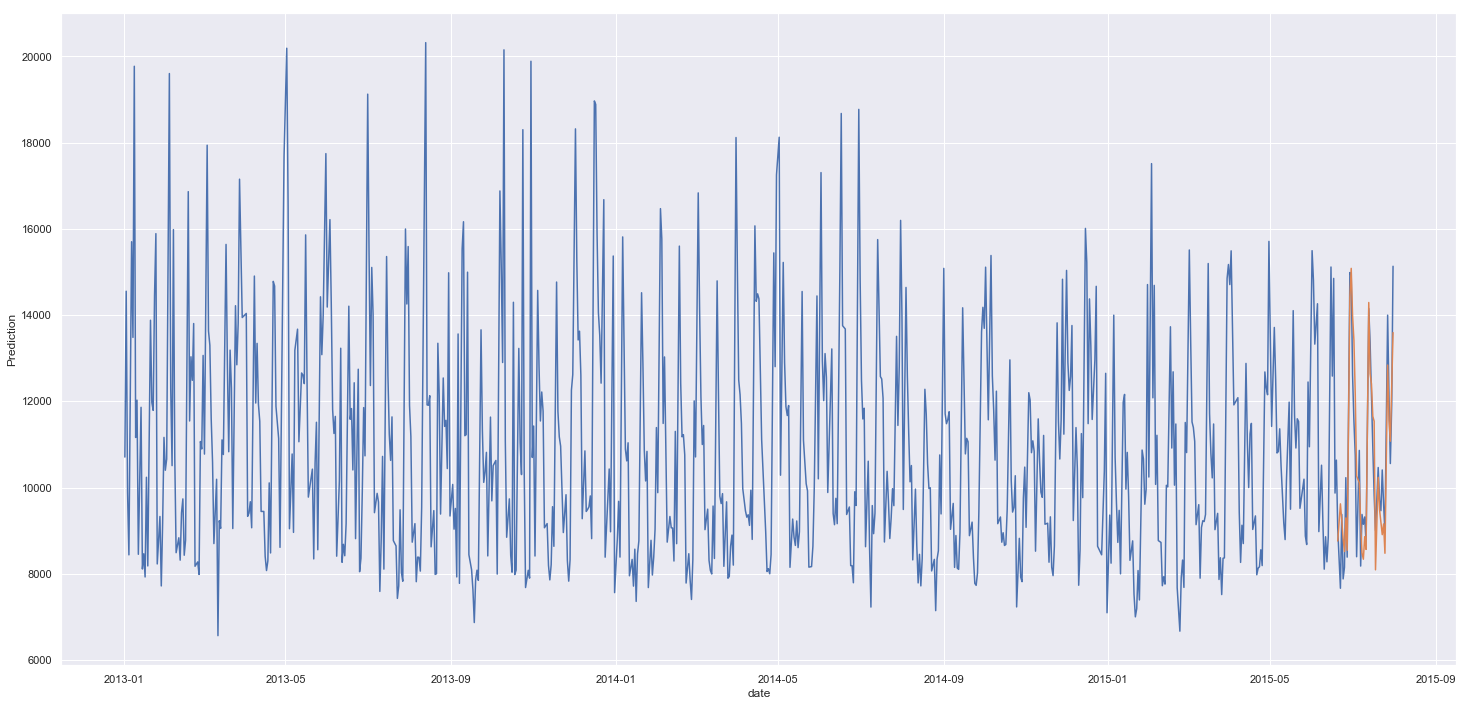

In [92]:
a = res[res['Store'] == 906]
a['date'] = pd.to_datetime( dict( year=a['Year'], month=a['Month'], day=a['Day'] ))

b = train[(train['Store'] == 906) & (train['Sales']>0)]

sns.lineplot( x='Date', y='Sales', data=b )
sns.lineplot( x='date', y='Prediction', data=a )

In [85]:
a.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight,day
824726,906,4,1,0,1,1,1,90.0,7.0,2010.0,0,0.0,0.0,2015,7,31,31,60.0,24187.75,0,15131.0,13592.582031,0.898327,0.101673,1.113181,2015-07-31
824727,906,3,1,0,1,1,1,90.0,7.0,2010.0,0,0.0,0.0,2015,7,30,31,60.0,24187.75,0,11907.0,12323.916992,1.035014,0.035014,0.966170,2015-07-30
824728,906,2,1,0,1,1,1,90.0,7.0,2010.0,0,0.0,0.0,2015,7,29,31,60.0,24187.75,0,10556.0,11073.736328,1.049047,0.049047,0.953246,2015-07-29
824729,906,1,1,0,1,1,1,90.0,7.0,2010.0,0,0.0,0.0,2015,7,28,31,60.0,24187.75,0,12122.0,11570.565430,0.954510,0.045490,1.047658,2015-07-28
824730,906,0,1,0,1,1,1,90.0,7.0,2010.0,0,0.0,0.0,2015,7,27,31,60.0,24187.75,0,13997.0,12840.761719,0.917394,0.082606,1.090044,2015-07-27


Mean Ratio of prediction and real sales data is 1.0024248600339267: store all
Mean ratio of prediction and real sales data is 0.9994484437634258: store 704
Mean ratio of prediction and real sales data is 0.9989383680900428: store 520
Mean ratio of prediction and real sales data is 0.9985539756736799: store 245


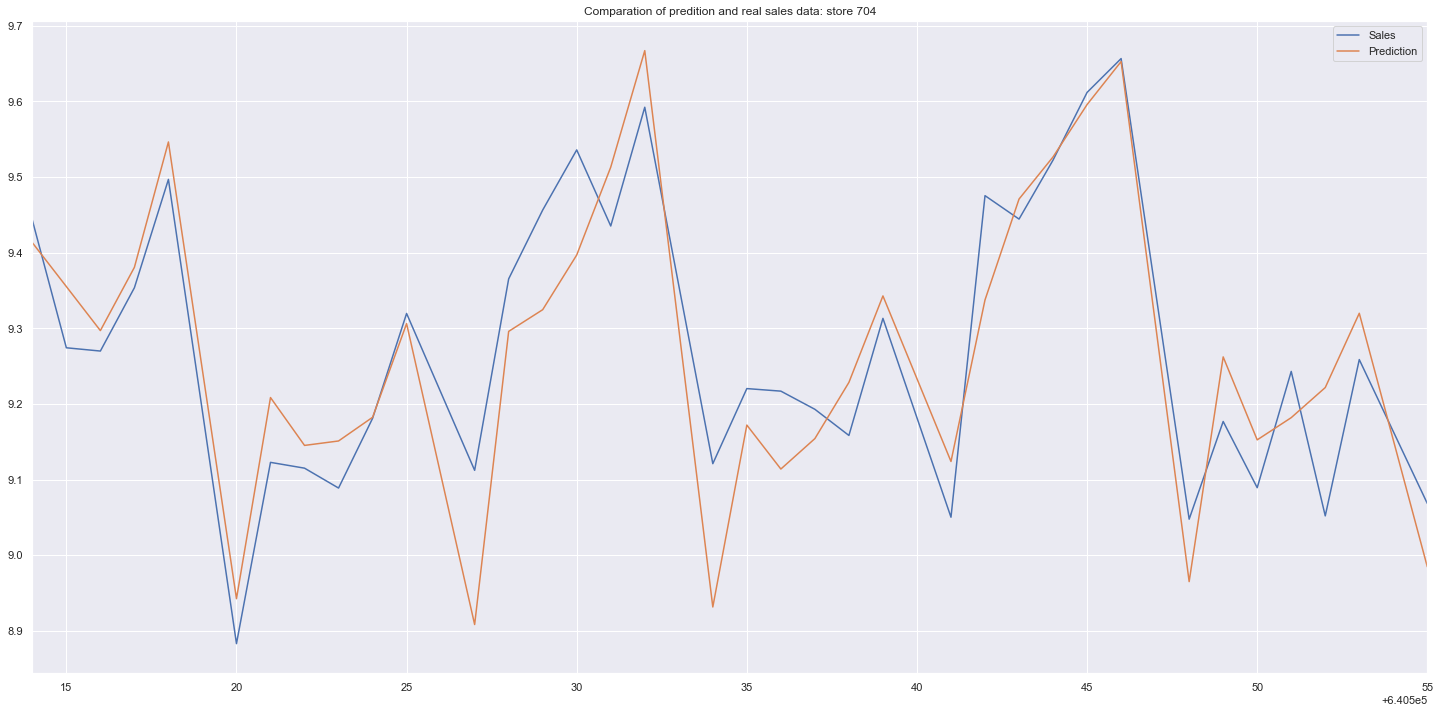

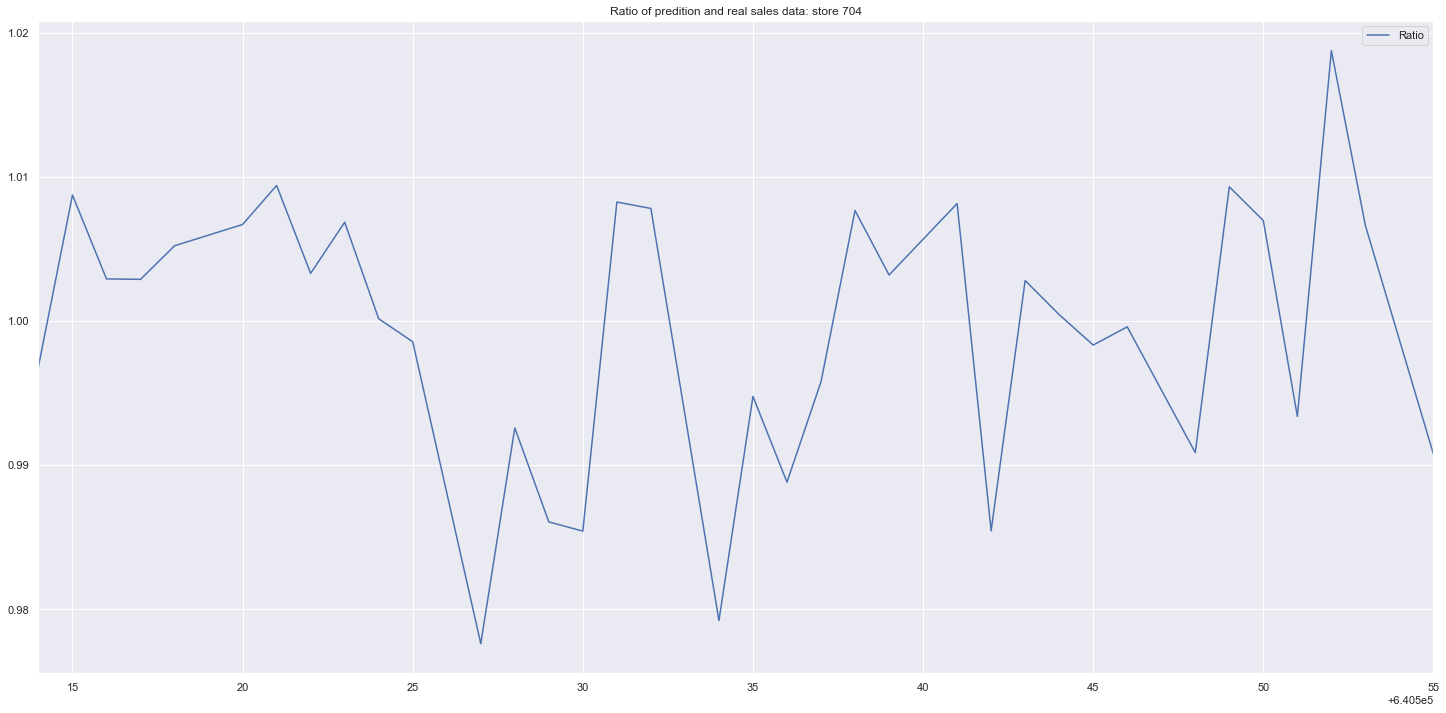

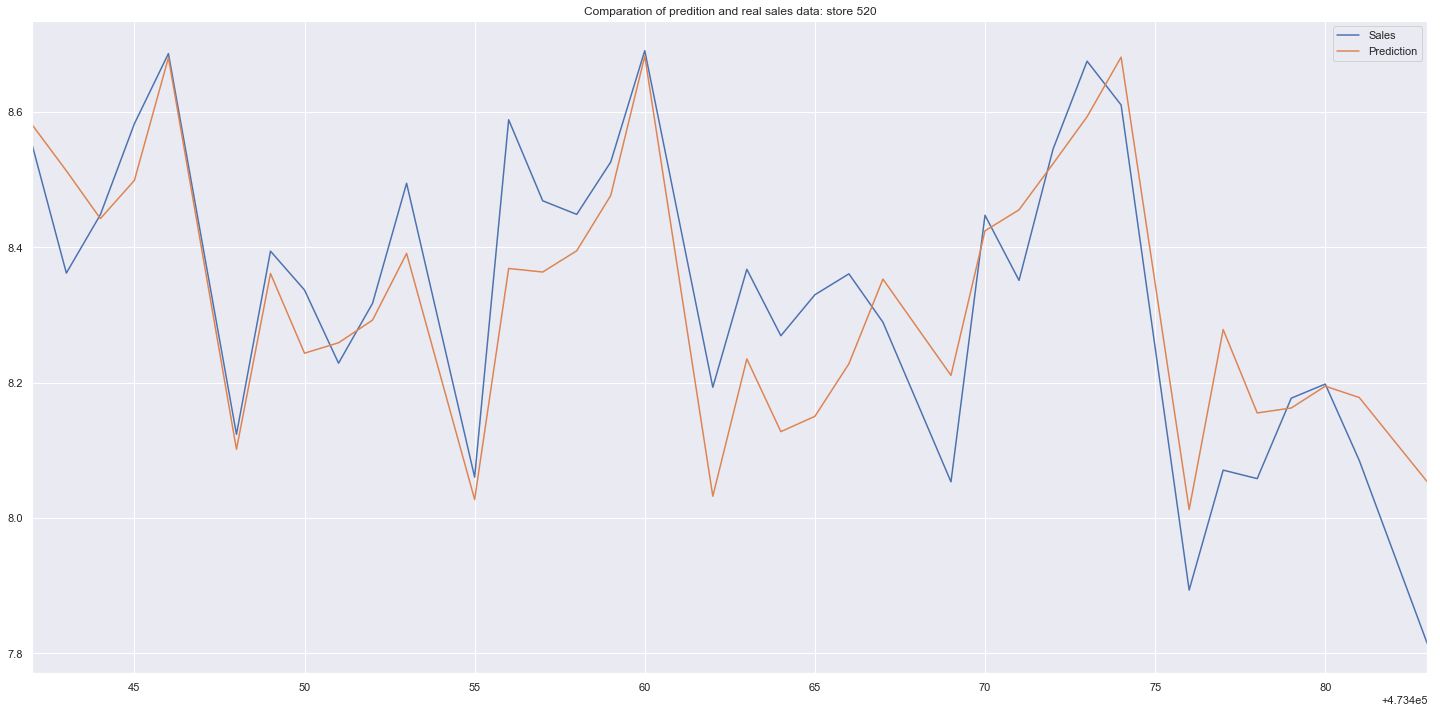

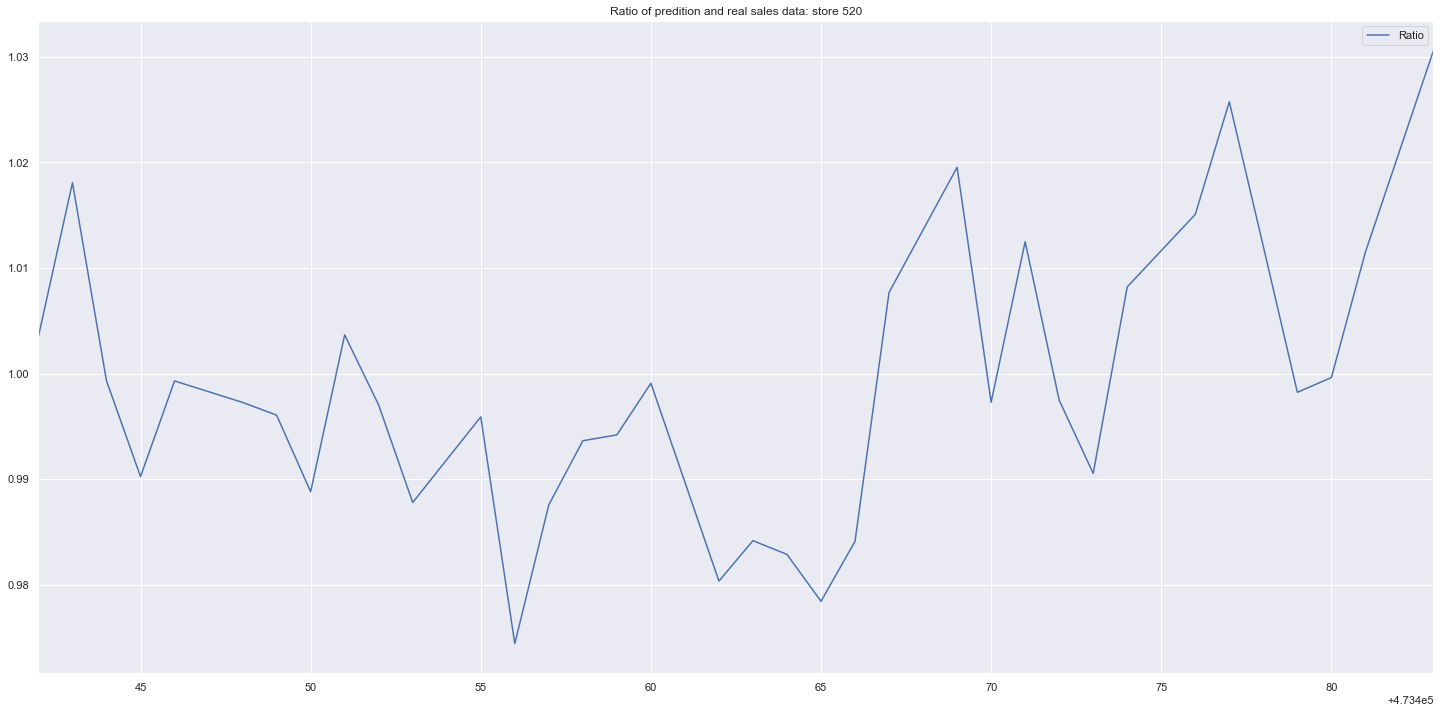

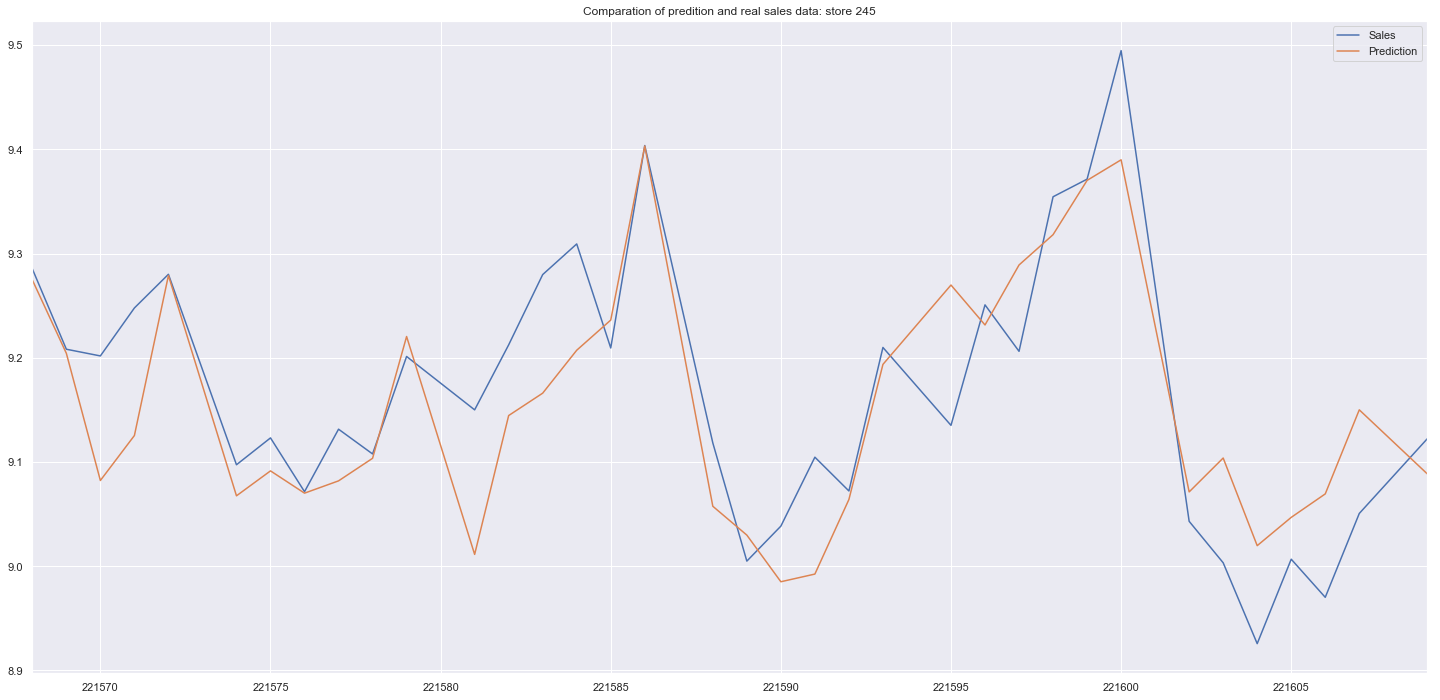

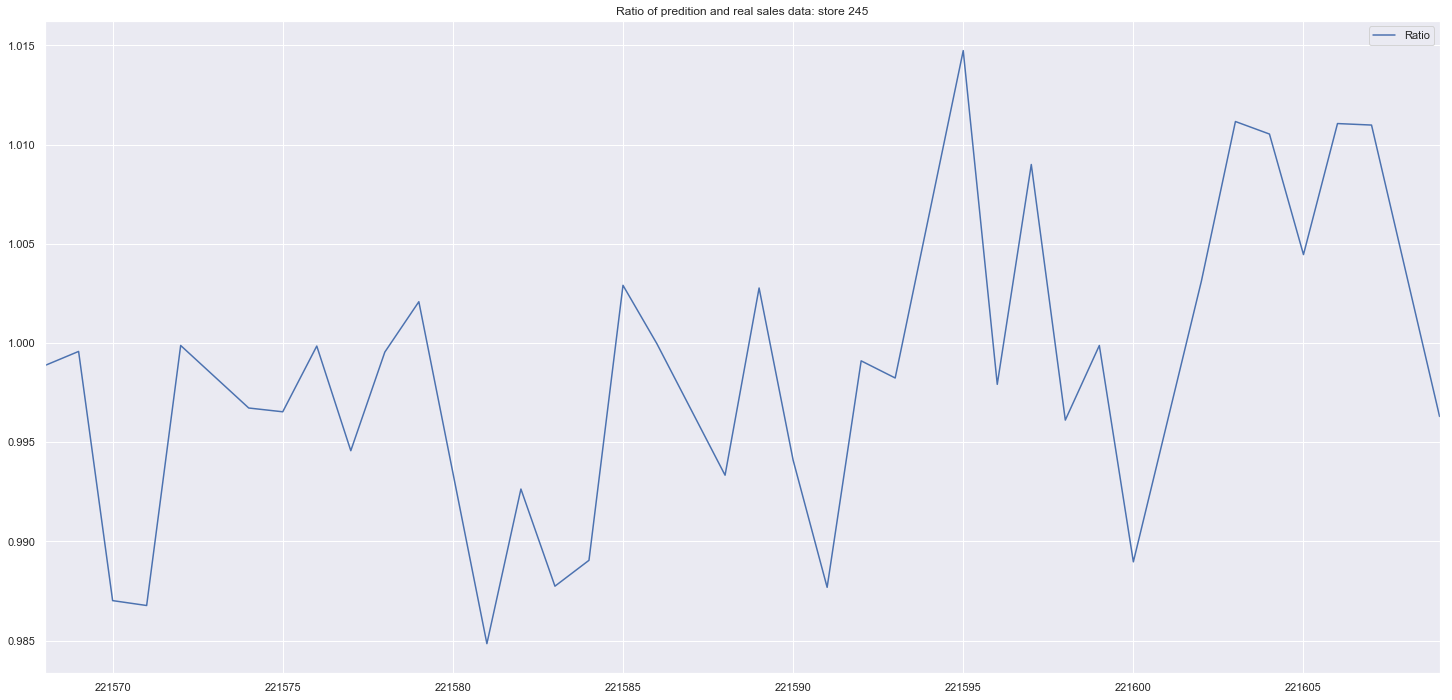

In [35]:
col_1 = ['Sales', 'Prediction']
col_2 = ['Ratio']

L = np.random.randint( low=1, high=1115, size=3 )
print( 'Mean Ratio of prediction and real sales data is {}: store all'.format( res.Ratio.mean() ) )

for i in L:
    s1 = pd.DataFrame( res[res['Store'] == i ], columns = col_1 )
    s2 = pd.DataFrame( res[res['Store'] == i ], columns = col_2 )
    s1.plot( title = 'Comparation of predition and real sales data: store {}'.format(i) )
    s2.plot( title = 'Ratio of predition and real sales data: store {}'.format(i) )
    print( 'Mean ratio of prediction and real sales data is {}: store {}'.format( s2.Ratio.mean(), i ) )

In [25]:
# the worst 10 samples
res.sort_values( ['Error'], ascending=False, inplace=True )
res[:10]

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
264207,292,4,0,0,0,1,1,1100.0,6.0,2009.0,0,0.0,0.0,2015,7,10,28,73.0,24187.00,0,6.920672,8.548178,1.235166,0.235166,0.809608
711449,782,4,0,0,0,3,3,5390.0,8.0,2003.0,1,1.0,2012.0,2015,6,26,26,142.0,42.25,0,7.260523,8.611728,1.186103,0.186103,0.843097
827582,909,2,1,0,0,1,3,1680.0,0.0,0.0,1,45.0,2009.0,2015,7,1,27,24187.0,67.50,0,8.174139,9.548629,1.168151,0.168151,0.856054
797965,876,5,0,0,0,1,1,21790.0,4.0,2005.0,1,18.0,2015.0,2015,7,4,27,123.0,2.25,0,9.596215,8.253420,0.860070,0.139930,1.162696
827591,909,0,0,0,0,1,3,1680.0,0.0,0.0,1,45.0,2009.0,2015,6,22,26,24186.0,67.25,0,10.634701,9.179318,0.863148,0.136852,1.158550
264213,292,5,0,0,0,1,1,1100.0,6.0,2009.0,0,0.0,0.0,2015,7,4,27,73.0,24186.75,0,7.406711,8.342337,1.126321,0.126321,0.887846
264218,292,0,1,0,0,1,1,1100.0,6.0,2009.0,0,0.0,0.0,2015,6,29,27,72.0,24186.75,0,10.280622,9.023319,0.877702,0.122298,1.139339
797963,876,0,0,0,0,1,1,21790.0,4.0,2005.0,1,18.0,2015.0,2015,7,6,28,123.0,2.50,0,10.215777,8.996422,0.880640,0.119360,1.135538
827590,909,1,0,0,0,1,3,1680.0,0.0,0.0,1,45.0,2009.0,2015,6,23,26,24186.0,67.25,0,10.310252,9.140197,0.886515,0.113485,1.128012
711448,782,5,0,0,0,3,3,5390.0,8.0,2003.0,1,1.0,2012.0,2015,6,27,26,142.0,42.25,0,7.714677,8.581433,1.112352,0.112352,0.898996


Weight correction
RMSPE for 0.990:0.129189
RMSPE for 0.991:0.126456
RMSPE for 0.992:0.124208
RMSPE for 0.993:0.122488
RMSPE for 0.994:0.121334
RMSPE for 0.995:0.120777
RMSPE for 0.996:0.120842
RMSPE for 0.997:0.121546
RMSPE for 0.998:0.122893
RMSPE for 0.999:0.124880
RMSPE for 1.000:0.127493
RMSPE for 1.001:0.130712
RMSPE for 1.002:0.134510
RMSPE for 1.003:0.138856
RMSPE for 1.004:0.143716
RMSPE for 1.005:0.149057
RMSPE for 1.006:0.154843
RMSPE for 1.007:0.161042
RMSPE for 1.008:0.167624
RMSPE for 1.009:0.174559
Best weight for Score:0.995    0.120777
dtype: float64


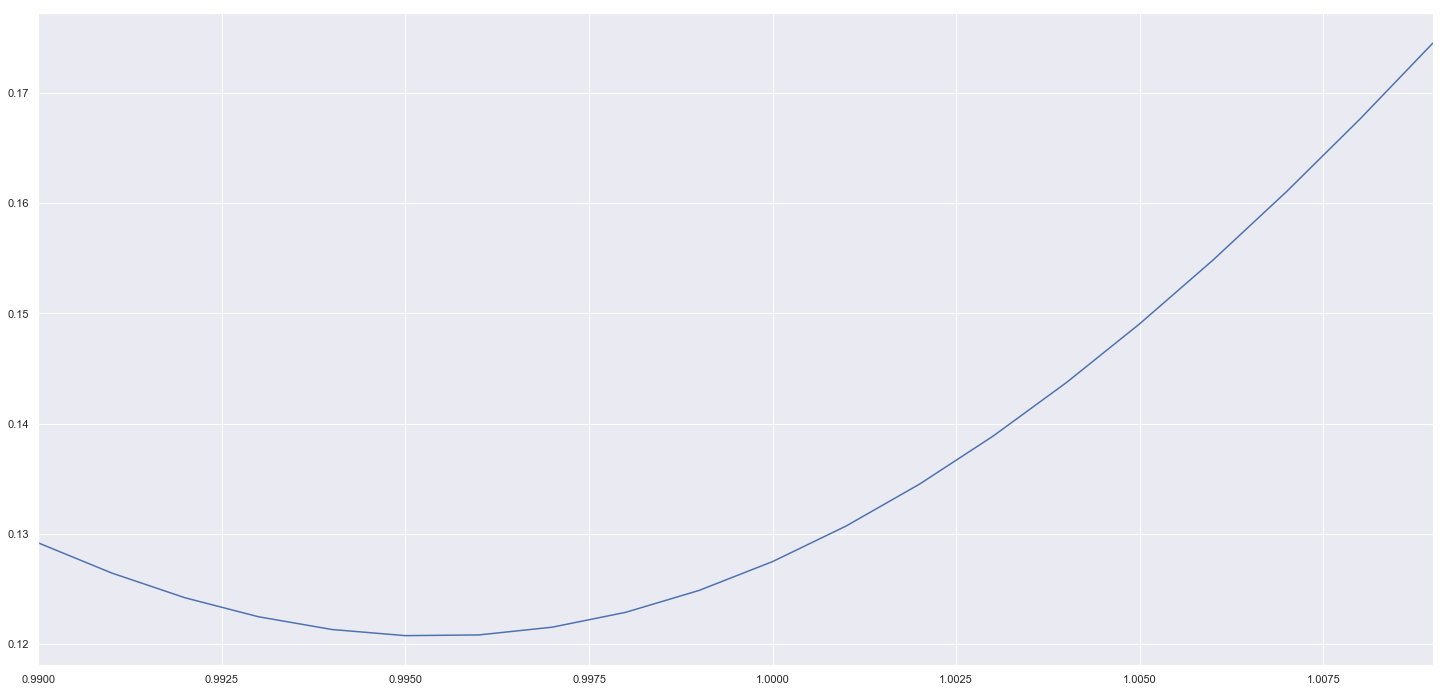

In [29]:
# whole correction
print( 'Weight correction' )
W = [ (0.990 + ( i/1000 )) for i in range( 20 )]
S = []
for w in W:
    error = rmspe( np.expm1( ho_ytest ), np.expm1( yhat*w ) ) 
    print( 'RMSPE for {:.3f}:{:.6f}'.format( w, error ) )
    S.append( error )
    
Score = pd.Series( S, index=W )
Score.plot()
BS = Score[Score.values == Score.values.min()]
print( 'Best weight for Score:{}'.format( BS ) )

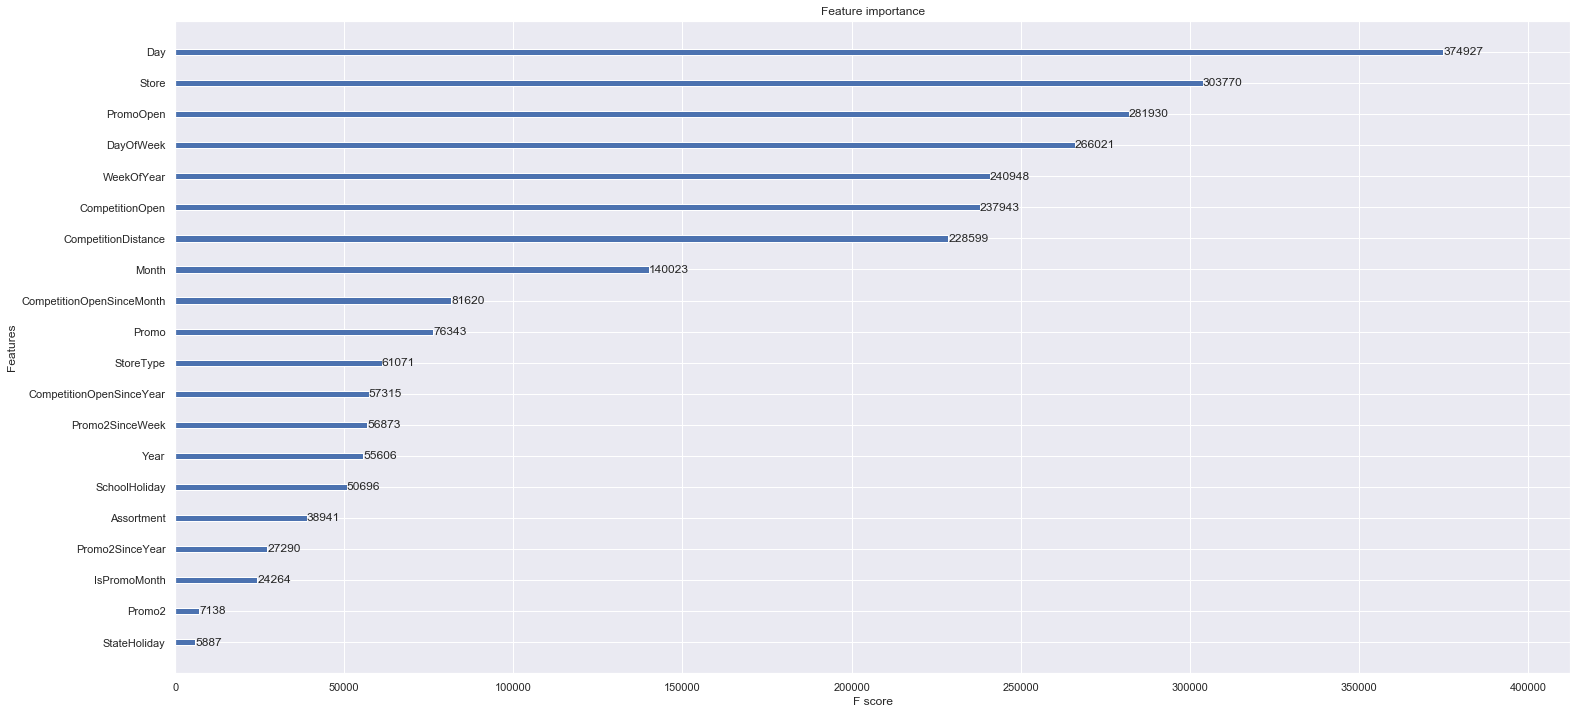

In [26]:
# feature importance
xgb.plot_importance( gbm )